# Design discussions LDA Mallet Implementation

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
SO_tag_filtered_nocode = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/clean_compl_data4.csv")
SO_tag_filtered_nocode = SO_tag_filtered_nocode.loc[SO_tag_filtered_nocode['label'] == 0]  # select only bugs records
SO_tag_filtered_nocode.head()

Unnamed: 0                                               text  label
1            1  buggy behavior selection screenshot http cloud...      0
4            4  enable pid pid alarm action expected behavior ...      0
5            5  script stopped adding video recent change yout...      0
9            9  org ull people info nico produce crash guez ul...      0
15          15  filter floating point background identified sm...      0

In [ ]:
#checkpoint
#save csv with limited columns
SO_tag_filtered_nocode['Id'] = SO_tag_filtered_nocode.index
SO_tag_filtered_nocode.to_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_text_processed.csv", columns=['Id','text'],index=False)

In [ ]:
SO_tag_filtered_nocode = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_text_processed.csv")
SO_tag_filtered_nocode.head()

Id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text
0  1   buggy behavior selection screenshot http cloud git hub user content png                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1  4   enable pid pid alarm action expected behavior alarm action pid pid enable disable hardware pid platform ramp oak may also affected actual behavior pid state change alarm activates step reproduce problem alarm handler work qmc control button flag set qmc control button flag case handled pid pid off function condition may able removed alarm handler keep generalized pid type main elif self alarm action alarm number ramp oak qmc device fuji pid fuji pid fuji pid set ramp oak elif pid control qmc control button flag internal external modbus pid control pid control mode pid control pid elif self alarm action alarm number ramp oak qmc device fuji pid fuji pid fuji pid set ramp oak elif pid control qmc control button flag internal external modbus pid control pid control mode pid control pid off elif self alarm action alarm number pid qmc device fuji pid fuji pid fuji pid seton off standby elif pid control qmc control button flag internal external modbus pid control pid control pid elif self alarm action alarm number pid qmc device fuji pid fuji pid fuji pid seton off standby elif pid control qmc control button flag internal external modbus pid control pi

# dataset visualizations

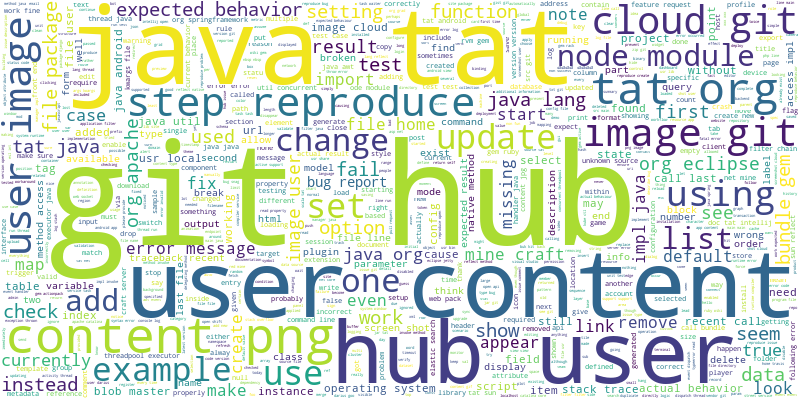

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(SO_tag_filtered_nocode['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

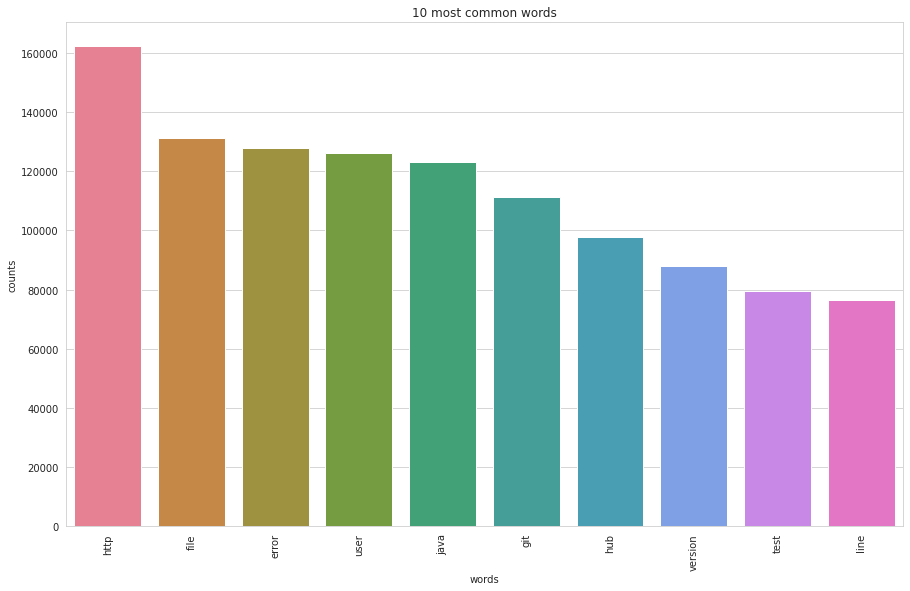

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(SO_tag_filtered_nocode['text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# sklearn default implementation of LDA Mallet

In [ ]:
#benchmark - no need to run
# the sklearn default implementation of LDAMallet
%%time

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, verbose = True)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Topics found via LDA:

Topic #0:
java tat org com impl event method run thread android

Topic #1:
http server error git com hub log service client file

Topic #2:
file line error test module type object node data value

Topic #3:
http user git hub image content issue page png version

Topic #4:
version file build error test run code window package git
CPU times: user 24.1 s, sys: 2.57 s, total: 26.6 s
Wall time: 28min 55s


# Generating bi-grams and tri-grams

In [ ]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

data_words = list(sent_to_words(SO_tag_filtered_nocode.text))

print(data_words[:1])

[['buggy', 'behavior', 'selection', 'screenshot', 'http', 'cloud', 'git', 'hub', 'user', 'content', 'png']]


In [ ]:
#checkpoint 

import pickle
#pickle.dump(data_words,'/content/drive/MyDrive/Research/ICSME 2021/SO_data_words.pkl')

#saving data words
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_words.pkl', 'wb') as handle:
    pickle.dump(data_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!pip install pyLDAvis

#frm here

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#opening saved data words.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_words.pkl', 'rb') as handle:
    data_words = pickle.load(handle)
# data_words

In [ ]:
import pyLDAvis
# import pyLDAvis.gensim_models
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# checkpoint
bigram_mod.save('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_bigram_mod')
trigram_mod.save('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_trigram_mod')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/sm

In [ ]:
# LOAD
bigram_mod = gensim.models.phrases.Phraser.load('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_bigram_mod')
trigram_mod = gensim.models.phrases.Phraser.load('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_trigram_mod')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


# lemmetization

In [ ]:
# stopwords
import nltk 
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']
import re

data_processed = []
stop_words = nltk.corpus.stopwords.words('english')

# bi-gram and tri-gram implementation
texts = [bigram_mod[doc] for doc in data_words]
texts = [trigram_mod[bigram_mod[doc]] for doc in data_words]

texts_out = []
# implement lemmatization and filter out unwanted part of speech tags
for sent in texts:
  doc = nlp(" ".join(sent)) 
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
# remove stopwords and short tokens again after lemmatization
texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out] 

data_ready = texts_out
data_ready

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

[['behavior', 'selection', 'screenshot', 'content'],
 ['enable',
  'alarm',
  'action',
  'expect',
  'behavior',
  'alarm',
  'action',
  'disable',
  'hardware',
  'platform',
  'may',
  'also',
  'affect',
  'actual',
  'behavior',
  'state',
  'change',
  'alarm',
  'activate',
  'step',
  'reproduce',
  'problem',
  'alarm',
  'handler',
  'work',
  'control',
  'button',
  'flag',
  'set',
  'control',
  'case',
  'handle',
  'function',
  'condition',
  'may',
  'able',
  'removed',
  'alarm',
  'handler',
  'keep',
  'generalize',
  'pid',
  'type',
  'main',
  'self',
  'alarm',
  'action',
  'alarm',
  'number',
  'ramp',
  'action',
  'alarm',
  'number',
  'ramp',
  'alarm',
  'action',
  'alarm',
  'number',
  'device',
  'action',
  'alarm',
  'number',
  'device',
  'may',
  'worth',
  'check',
  'pattern',
  'occur',
  'elsewhere',
  'code',
  'key',
  'build',
  'number',
  'bracket',
  'show',
  'box',
  'platform',
  'version',
  'connect',
  'device',
  'roast',
  '

In [ ]:
# from nltk.stem import WordNetLemmatizer

# wnl = WordNetLemmatizer()
# data_processed = []
# stop_words = nltk.corpus.stopwords.words('english')
# for doc in data_words:
#     doc_out = []
#     for wd in doc:
#         if wd not in stop_words:  # remove stopwords
#             lemmatized_word = ""
#             lemmatized_word = wnl.lemmatize(wd)  # lemmatize
#             if lemmatized_word:
#                 doc_out.append(lemmatized_word)
#         else:
#             continue
#     data_processed.append(doc_out)
# data_ready = data_processed


In [ ]:
#checkpoint
#saving lemmetize
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_ready.pkl', 'wb') as handle:
    pickle.dump(data_ready, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_ready.pkl', 'rb') as handle:
    data_ready = pickle.load(handle)
# data_ready

# vocabulary

In [ ]:
# print vocab
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 53202


In [ ]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# checkpoint
# saving corpus
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_corpus.pkl', 'wb') as handle:
    pickle.dump(corpus, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_corpus.pkl', 'rb') as handle:
    corpus = pickle.load(handle)

In [ ]:
import pandas as pd
# creating a dictionary corpus
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

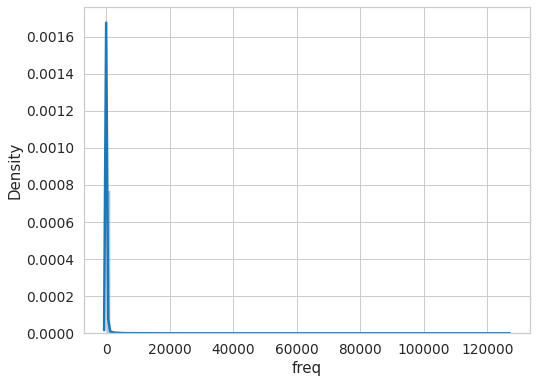

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [ ]:
dict_df.sort_values('freq', ascending=False).head(10)

freq
file     126429
error    103330
user      94544
use       90314
http      80827
test      74293
version   72447
line      70991
issue     65543
run       65240

In [ ]:
# !pip install --upgrade pip

In [ ]:
extension = dict_df[dict_df.freq>5000].index.tolist()

In [ ]:
#checkpoint
#saving extension
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_extension.pkl', 'wb') as handle:
    pickle.dump(extension, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_extension.pkl', 'rb') as handle:
    extension = pickle.load(handle)

In [ ]:
# to filter words greater then 5000 freq 
ids=[id2word.token2id[extension[i]] for i in range(len(extension))]
id2word.filter_tokens(bad_ids=ids)

# removing stopwords and outliers and frequent words to reduce vocabulary

In [ ]:
#here look for nouns, verbs .... 

import nltk
stop_words = nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
# add high frequency words to stop words list
stop_words.extend(extension)
wnl = WordNetLemmatizer()
data_processed = []
for doc in data_words:
    doc_out = []
    for wd in doc:
        if wd not in stop_words:  # remove stopwords
            lemmatized_word = ""
            lemmatized_word = wnl.lemmatize(wd)  # lemmatize
            if lemmatized_word:
                doc_out.append(lemmatized_word)
        else:
            continue
    data_processed.append(doc_out)
data_ready = data_processed

In [ ]:
data_ready

[['buggy', 'selection', 'git', 'png'],
 ['pid',
  'pid',
  'alarm',
  'expected',
  'alarm',
  'pid',
  'pid',
  'disable',
  'hardware',
  'pid',
  'ramp',
  'oak',
  'affected',
  'pid',
  'alarm',
  'activates',
  'alarm',
  'qmc',
  'qmc',
  'handled',
  'pid',
  'pid',
  'condition',
  'removed',
  'alarm',
  'keep',
  'generalized',
  'pid',
  'elif',
  'alarm',
  'alarm',
  'ramp',
  'oak',
  'qmc',
  'fuji',
  'pid',
  'fuji',
  'pid',
  'fuji',
  'pid',
  'ramp',
  'oak',
  'elif',
  'pid',
  'qmc',
  'external',
  'modbus',
  'pid',
  'pid',
  'pid',
  'pid',
  'elif',
  'alarm',
  'alarm',
  'ramp',
  'oak',
  'qmc',
  'fuji',
  'pid',
  'fuji',
  'pid',
  'fuji',
  'pid',
  'ramp',
  'oak',
  'elif',
  'pid',
  'qmc',
  'external',
  'modbus',
  'pid',
  'pid',
  'pid',
  'pid',
  'elif',
  'alarm',
  'alarm',
  'pid',
  'qmc',
  'fuji',
  'pid',
  'fuji',
  'pid',
  'fuji',
  'pid',
  'seton',
  'standby',
  'elif',
  'pid',
  'qmc',
  'external',
  'modbus',
  'pid',
  'p

In [ ]:
#checkpoint
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_ready_last.pkl', 'wb') as handle:
    pickle.dump(data_ready, handle, protocol=pickle.HIGHEST_PROTOCOL)

#here2

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_data_ready_last.pkl', 'rb') as handle:
    data_ready = pickle.load(handle)

In [ ]:
# recreate Dictionary
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 81237


In [ ]:
# Filter out words that occur less than 20 documents, or more than
# 50% of the documents.
id2word.filter_extremes(no_below=20, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 13120


In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
#checkpoint
# saving corpus
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_corpus.pkl', 'wb') as handle:
    pickle.dump(corpus, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
with open('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_corpus.pkl', 'rb') as handle:
    corpus = pickle.load(handle)

# installing mallet optimizer

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-09-12 18:53:28--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.3MB/s    in 1.3s    

2021-09-12 18:53:29 (12.3 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'

# Training the model and optimizing the number of topics 

In [ ]:
%%time
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

CPU times: user 31 µs, sys: 0 ns, total: 31 µs
Wall time: 43.2 µs


In [ ]:
from tqdm import tqdm
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
   
   # https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
#training
%%time
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit= 70, step=5) 

100%|██████████| 14/14 [3:48:02<00:00, 977.30s/it] 

CPU times: user 23min 44s, sys: 18.8 s, total: 24min 3s
Wall time: 3h 48min 2s


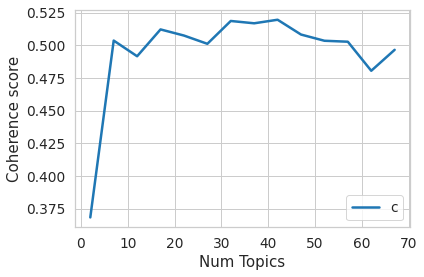

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Show graph
limit=70; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3683
Num Topics = 7  has Coherence Value of 0.5036
Num Topics = 12  has Coherence Value of 0.4916
Num Topics = 17  has Coherence Value of 0.5121
Num Topics = 22  has Coherence Value of 0.5074
Num Topics = 27  has Coherence Value of 0.5011
Num Topics = 32  has Coherence Value of 0.5186
Num Topics = 37  has Coherence Value of 0.5168
Num Topics = 42  has Coherence Value of 0.5195
Num Topics = 47  has Coherence Value of 0.5082
Num Topics = 52  has Coherence Value of 0.5034
Num Topics = 57  has Coherence Value of 0.5027
Num Topics = 62  has Coherence Value of 0.4805
Num Topics = 67  has Coherence Value of 0.4965


# optimal model generation

In [ ]:
from pprint import pprint
# Select the model and print the topics
optimal_model = model_list[4] # change it if need for optimal topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(1,
  '0.020*"auth" + 0.019*"kube" + 0.016*"timeout" + 0.016*"failed" + '
  '0.016*"volume" + 0.014*"elastic" + 0.013*"shift" + 0.012*"pod" + '
  '0.012*"xxx" + 0.012*"bernet"'),
 (15,
  '0.031*"chrome" + 0.027*"err" + 0.026*"react" + 0.018*"firefox" + '
  '0.018*"min" + 0.017*"desktop" + 0.014*"width" + 0.014*"javascript" + '
  '0.014*"promise" + 0.013*"ode"'),
 (21,
  '0.333*"git" + 0.046*"dev" + 0.028*"blob" + 0.025*"cli" + 0.020*"repo" + '
  '0.016*"workspace" + 0.013*"pkg" + 0.013*"dashboard" + 0.013*"lab" + '
  '0.013*"team"'),
 (6,
  '0.018*"side" + 0.018*"bot" + 0.015*"chat" + 0.015*"card" + 0.015*"jpg" + '
  '0.014*"mobile" + 0.013*"left" + 0.012*"track" + 0.012*"contact" + '
  '0.012*"hit"'),
 (10,
  '0.034*"mine" + 0.030*"craft" + 0.026*"red" + 0.022*"mod" + 0.017*"world" + '
  '0.016*"category" + 0.013*"gui" + 0.013*"kit" + 0.013*"ticket" + '
  '0.011*"magen"'),
 (18,
  '0.052*"python" + 0.028*"args" + 0.025*"recent" + 0.020*"traceback" + '
  '0.019*"count" + 0.014*"utils"

In [ ]:
#checkpoint
import pickle
pickle.dump(optimal_model, open("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_ldamallet_topics.pkl", "wb"))

# save the optimal model

In [ ]:
import pandas as pd

In [ ]:
# also run the imports in previous cells if you load this in a new kernel.
import pickle
ldamallet_14 = pickle.load(open("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_ldamallet_topics.pkl", "rb"))

In [ ]:
tm_results = ldamallet_14[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet_14.show_topic(n, topn=20)] for n in range(0, ldamallet_14.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet_14.num_topics+1)]).T
topics_df.head()

Topic 1  Topic 2   Topic 3  ...       Topic 20    Topic 21 Topic 22
Term1  abstract     auth   setting  ...           html         max      git
Term2   eclipse     kube   changed  ...            doc       range      dev
Term3      lang  timeout  password  ...        defined  expression     blob
Term4    apache   failed   enabled  ...  documentation      length      cli
Term5  executor   volume       msg  ...         called        word     repo

[5 rows x 22 columns]

In [ ]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet_14.num_topics+1)] )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


Terms per Topic
Topic1   abstract, eclipse, lang, apache, executor, xml, sun, runner, factory, reflect, snapshot, servlet, concurrent, parent, springframework, threadpool, grad, spring, execution, processor
Topic2   auth, kube, timeout, failed, volume, elastic, shift, pod, xxx, bernet, sending, mini, deploy, ssl, policy, loaded, street, kind, endpoint, ctl                                       
Topic3   setting, changed, password, enabled, msg, running, shell, expected, reset, power, ssh, sign, extra, username, disable, disabled, summary, paste, fails, alert                        
Topic4   png, git, admin, login, graph, shot, displayed, permission, www, broken, shown, showing, pipeline, hash, aaaa, img, website, baz, logged, stash                                      
Topic5   linux, failed, ubuntu, tmp, zip, flow, running, dir, kernel, total, cpu, archive, disk, vim, pid, cat, starting, software, utc, sec                                                  
Topic6   tab, drop, selected, expected, theme, atom, clicking, panel, background, selection, visible, press, area, preview, gif, focus, bottom, cursor, blank, mouse                          
Topic7   side, bot, chat, card, jpg, mobile, left, track, contact, hit, phone, effect, term, large, lot, small, turn, audio, big, amount                                                      
Topic8   int, channel, const, byte, cpp, buffer, std, static, void, symbol, signal, pdf, char, free, rust, mongo, proto, gcc, netty, struct                                                   
Topic9   cache, sql, scala, parser, statement, builder, mysql, pool, queue, join, lock, insert, uri, scope, dot, batch, topic, syntax, operator, prefix                                       
Topic10  microsoft, aws, trace, terraform, framework, async, asset, studio, success, azure, boolean, previous, visual, region, sdk, thrown, exe, debugger, dll, book                          
Topic11  mine, craft, red, mod, world, category, gui, kit, ticket, magen, original, author, forge, chunk, visit, priority, catalog, spigot, bus, func                                         
Topic12  src, android, google, vendor, layout, medium, loop, widget, dart, front, zone, patch, nbsp, lang, fragment, quot, stage, calendar, analyzer, touch                                   
Topic13  api, json, schema, intellij, domain, rest, progress, validation, member, definition, font, awt, reader, ref, pattern, multi, ide, idea, eventqueue, validate                         
Topic14  expected, label, latest, day, related, clear, testing, working, condition, relevant, fill, checked, real, reporting, forum, scenario, general, duplicate, hour, operating            
Topic15  bundle, missing, gem, working, angular, demo, dialog, refresh, middleware, router, history, expected, overflow, initial, logging, actionpack, modal, rack, vue, imported             
Topic16  chrome, err, react, firefox, min, desktop, width, javascript, promise, ode, typeerror, edge, height, beta, prop, chart, development, dist, dom, mac                                  
Topic17  created, added, updated, adding, removed, apps, existing, grid, creating, metadata, required, deleted, backend, saved, mail, original, exists, bucket, external, reported            
Topic18  found, usr, bin, ruby, gem, txt, installed, plugins, fails, spec, opt, travis, wiki, rvm, loading, pre, env, global, vagrant, installation                                           
Topic19  python, args, recent, traceback, count, utils, cell, raise, kwargs, django, func, cmd, filename, sort, def, meta, params, raw, virtual, str                                          
Topic20  html, doc, defined, documentation, called, generated, passed, implementation, short, usage, valid, lead, includes, inside, implement, publish, hard, board, incorrect, developer     
Topic21  max, range, expression, length, word, double, plot, generator, analysis, random, csv, dataset, scale, float, bound, nav, zoom, matrix, fit, dynamic        

# visualizations on optimal model

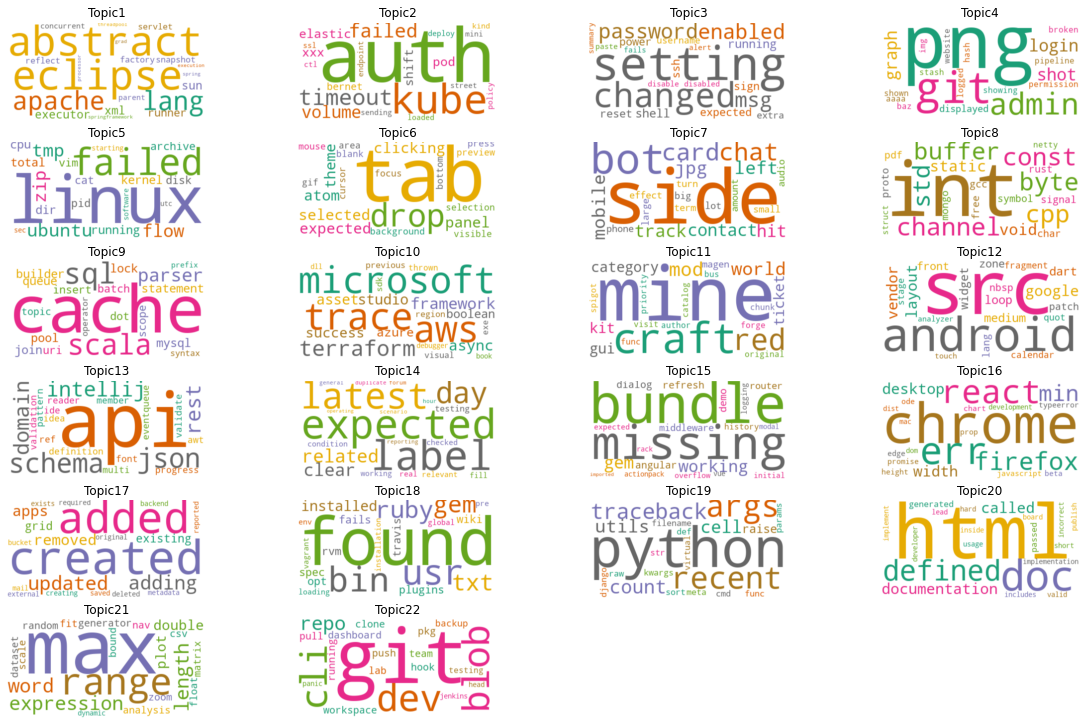

In [ ]:
# import wordclouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(22):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(7, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [ ]:
from gensim.models.ldamodel import LdaModel
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) # original function has 'eta=0' argument
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
ldagensim = convertldaMalletToldaGen(ldamallet_14)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['Text'] = SO_tag_filtered_nocode.text
corpus_topic_df['Id'] = SO_tag_filtered_nocode.Id
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

Text  ...                                                                                                                                                                Topic Terms
0  buggy behavior selection screenshot http cloud git hub user content png                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ...  png, git, admin, login, graph, shot, displayed, permission, www, broken, shown, showing, pipeline, hash, aaaa, img, website, baz, logged, stash                          
1  enable pid pid alarm action expected behavior alarm action pid pid enable disable hardware pid platform ramp oak may also affected actual behavior pid state change alarm activates step reproduce problem alarm handler work qmc control button flag set qmc control button flag case handled pid pid off function condition may able removed alarm handler keep generalized pid type main elif self alarm action alarm number ramp oak qmc device fuji pid fuji pid fuji pid set ramp oak elif pid control qmc control button flag internal external modbus pid control pid control mode pid control pid elif self alarm action alarm number ramp oak qmc device fuji pid fuji pid fuji pid set ramp oak elif pid control qmc control button flag internal external modbus pid control pid control mode pid control pid off elif self alarm action alarm number pid qmc device fuji pid fuji pid fuji pid seton off standby elif pid control qmc control button flag internal external modbus pid control pid control pid elif self alarm action alarm number pid qmc device fuji pid fuji pid fuji pid seton off standby elif pid control qmc control button flag internal external modbus pid control pid control pid off might worth checking pattern occurs elsewhere code key press handler specification artisan version artisan build number bracket shown box platform mac window linux version connected device roasting machine arduino pid firmware  ...  linux, failed, ubuntu, tmp, zip, flow, running, dir, kernel, total, cpu, archive, disk, vim, pid, cat, starting, software, utc, sec                                      
2  script stopped adding video recent change youtube layout broke script probably caused element name altered                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
#predictions file
corpus_topic_df.to_csv('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv')

In [ ]:
import numpy as np
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

Dominant Topic  Doc_Count  Total_Docs_Perc
0   1               6075       2.64           
1   2               9680       4.20           
2   3               10257      4.45           
3   4               17132      7.43           
4   5               9521       4.13           
5   6               19591      8.50           
6   7               15329      6.65           
7   8               9619       4.17           
8   9               8209       3.56           
9   10              7726       3.35           
10  11              12679      5.50           
11  12              6319       2.74           
12  13              7800       3.38           
13  14              10694      4.64           
14  15              8011       3.48           
15  16              12430      5.39           
16  17              10904      4.73           
17  18              6583       2.86           
18  19              8811       3.82           
19  20              11843      5.14           
20  21              13459      5.84           
21  22              7809       3.39

<BarContainer object of 22 artists>

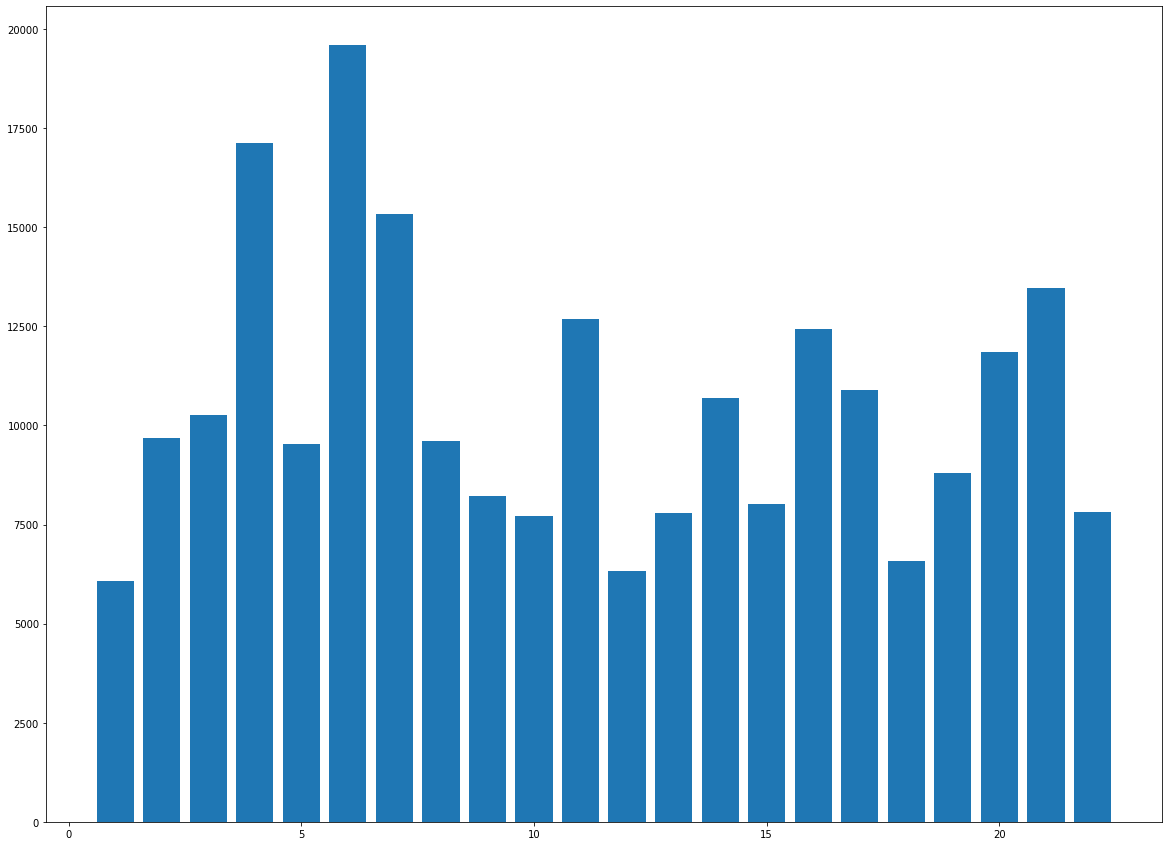

In [ ]:
plt.bar(x=dominant_topic_df['Dominant Topic'], height = dominant_topic_df['Doc_Count'])

In [ ]:
import pandas as pd
corpus_topic_df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv')

In [ ]:
corpus_topic_df.tail(20)

Unnamed: 0  ...                                                                                                                                                                            Topic Terms
230461  230461      ...  tab, drop, selected, expected, theme, atom, clicking, panel, background, selection, visible, press, area, preview, gif, focus, bottom, cursor, blank, mouse                          
230462  230462      ...  max, range, expression, length, word, double, plot, generator, analysis, random, csv, dataset, scale, float, bound, nav, zoom, matrix, fit, dynamic                                  
230463  230463      ...  setting, changed, password, enabled, msg, running, shell, expected, reset, power, ssh, sign, extra, username, disable, disabled, summary, paste, fails, alert                        
230464  230464      ...  src, android, google, vendor, layout, medium, loop, widget, dart, front, zone, patch, nbsp, lang, fragment, quot, stage, calendar, analyzer, touch                                   
230465  230465      ...  created, added, updated, adding, removed, apps, existing, grid, creating, metadata, required, deleted, backend, saved, mail, original, exists, bucket, external, reported            
230466  230466      ...  chrome, err, react, firefox, min, desktop, width, javascript, promise, ode, typeerror, edge, height, beta, prop, chart, development, dist, dom, mac                                  
230467  230467      ...  bundle, missing, gem, working, angular, demo, dialog, refresh, middleware, router, history, expected, overflow, initial, logging, actionpack, modal, rack, vue, imported             
230468  230468      ...  setting, changed, password, enabled, msg, running, shell, expected, reset, power, ssh, sign, extra, username, disable, disabled, summary, paste, fails, alert                        
230469  230469      ...  max, range, expression, length, word, double, plot, generator, analysis, random, csv, dataset, scale, float, bound, nav, zoom, matrix, fit, dynamic                                  
230470  230470      ...  side, bot, chat, card, jpg, mobile, left, track, contact, hit, phone, effect, term, large, lot, small, turn, audio, big, amount                                                      
230471  230471      ...  setting, changed, password, enabled, msg, running, shell, expected, reset, power, ssh, sign, extra, username, disable, disabled, summary, paste, fails, alert                        
230472  230472      ...  api, json, schema, intellij, domain, rest, progress, validation, member, definition, font, awt, reader, ref, pattern, multi, ide, idea, eventqueue, validate                         
230473  230473      ...  tab, drop, selected, expected, theme, atom, clicking, panel, background, selection, visible, press, area, preview, gif, focus, bottom, cursor, blank, mouse                          
230474  230474      ...  mine, craft, red, mod, world, category, gui, kit, ticket, magen, original, author, forge, chunk, visit, priority, catalog, spigot, bus, func                                         
230475  230475      ...  html, doc, defined, documentation, called, generated, passed, implementation, short, usage, valid, lead, includes, inside, implement, publish, hard, board, incorrect, developer     
230476  230476      ...  max, range, expression, length, word, double, plot, generator, analysis, random, csv, dataset, scale, float, bound, nav, zoom, matrix, fit, dynamic                                  
230477  230477      ...  bundle, missing, gem, working, angular, demo, dialog, refresh, middleware, router, history, expected, overflow, initial, logging, actionpack, modal, rack, vue, imported             
230478  230478      ...  side, bot, chat, card, jpg, mobile, left, track, contact, hit, phone, effect, term, large, lot, small, turn, audio, big, amount                                                      
230479  230479      ...  abstract, eclipse, lang, apache, executor, xml, su

In [ ]:
# data_src = 'SE' # SO | SE
# data_src_urls = {
#     'SO': 'stackoverflow.com',
#     'SE': 'softwareengineering.stackexchange.com'
# }
df_lda = pd.read_csv(f"/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv")
print(f"{len(df_lda.index)} rows imported.")
df_lda = df_lda[['Id', 'Text', 'Dominant Topic', 'Contribution %', 'Topic Terms']]
# df_lda.insert(1, 'URL', f"https://{data_src_urls[data_src]}/questions/" + df_lda['Id'].astype(str) + '/')
# df_lda['IsDesign'] = ""
df_lda['Label'] = ""
df_lda.head()

230481 rows imported.


Id  ... Label
0  1   ...      
1  4   ...      
2  5   ...      
3  9   ...      
4  15  ...      

[5 rows x 6 columns]

In [ ]:
#checkpoint
df_lda.to_csv('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv',index=False)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_tag_filtered_nocode_LDA_predictions.csv')
test.head()

Id  ... Label
0  1   ... NaN  
1  4   ... NaN  
2  5   ... NaN  
3  9   ... NaN  
4  15  ... NaN  

[5 rows x 6 columns]

In [ ]:
top = df_lda.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False))).reset_index(drop=True)
top.head(30)

Id  ... Label
0   138425  ...      
1   384524  ...      
2   281893  ...      
3   411851  ...      
4   91585   ...      
5   197533  ...      
6   84559   ...      
7   270046  ...      
8   85845   ...      
9   18274   ...      
10  200283  ...      
11  195813  ...      
12  120326  ...      
13  20637   ...      
14  248615  ...      
15  117358  ...      
16  320870  ...      
17  49124   ...      
18  408428  ...      
19  165870  ...      
20  86187   ...      
21  348469  ...      
22  382599  ...      
23  181247  ...      
24  232146  ...      
25  137357  ...      
26  231660  ...      
27  265437  ...      
28  98613   ...      
29  342032  ...      

[30 rows x 6 columns]

In [ ]:
top.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230481 entries, 0 to 230480
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              230481 non-null  int64  
 1   Text            230481 non-null  object 
 2   Dominant Topic  230481 non-null  int64  
 3   Contribution %  230481 non-null  float64
 4   Topic Terms     230481 non-null  object 
 5   Label           230481 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 10.6+ MB


In [ ]:
top.to_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SO_top_answers.csv", index=False)

# generate samples of each topic for label naming




In [ ]:
lda = top.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False)))

In [ ]:
lda_1 = lda.reset_index(drop = True)

In [ ]:
lda_labelling = lda_1.groupby('Dominant Topic').head(10)
lda_labelling.tail(20)

Id  ... Label
209213  11544   ...      
209214  315509  ...      
209215  391052  ...      
209216  252954  ...      
209217  468606  ...      
209218  210269  ...      
209219  37145   ...      
209220  342645  ...      
209221  352881  ...      
209222  149137  ...      
222672  306061  ...      
222673  87688   ...      
222674  198710  ...      
222675  48697   ...      
222676  119727  ...      
222677  433646  ...      
222678  156856  ...      
222679  265368  ...      
222680  140088  ...      
222681  21092   ...      

[20 rows x 6 columns]

In [ ]:
lda_labelling.to_csv("/content/drive/MyDrive/ColabNotebooks/MscProj/Advanced/TM/SE_top_answers.csv", index=False)